In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Analyze S&P Data

In [83]:
# extract from shiller's
snp = pd.read_excel("data/shiller_parsed.xlsx")
snp.tail()
# drop 2013 - 2016 due to lack of real Price and real Dividend Data
snp.drop(list(range(142, 146)), axis=0, inplace = True)


Text(0, 0.5, 'Price')

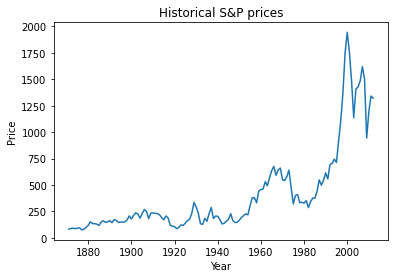

In [84]:
# Historical S&P prices
_=plt.plot(snp['Year'], snp['RealP'])
_=plt.title("Historical S&P prices")
plt.xlabel('Year')
plt.ylabel('Price')

We want to detrend the data according to a long run avg lambda = (1 + g)

Growth Factor (g): 0.017275532726949372


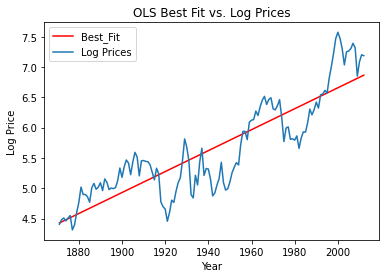

In [85]:
# OLS to get gt + log(P_0) = log(P_t)
X = np.vstack([np.ones_like(snp['Year']), snp['Year']]).transpose()
y = np.log(snp['RealP']).to_numpy()
W = np.linalg.inv(X.transpose() @ X) @ (X.transpose() @ y)
g = W[1]
print("Growth Factor (g):", g)

# Plot log prices vs linear regression
best_fit_y = W @ np.vstack([np.ones_like(snp['Year']), snp['Year']])
plt.plot(snp['Year'], best_fit_y, label ='Best_Fit', c = 'red')
plt.plot(snp['Year'], np.log(snp['RealP']), label = 'Log Prices')
plt.title("OLS Best Fit vs. Log Prices")
plt.xlabel("Year")
plt.ylabel("Log Price")
plt.legend()

In [86]:
# Detrend each price according to (1 + g)^t
snp['detrended_P'] = snp['RealP']/(1+g)**(snp.index)
snp['detrended_P']

0       82.031310
1       86.938590
2       87.876372
3       82.412936
4       84.797362
          ...    
137    143.881214
138     88.809636
139    110.423617
140    121.923587
141    118.077241
Name: detrended_P, Length: 142, dtype: float64

Text(0, 0.5, 'Detrended Price')

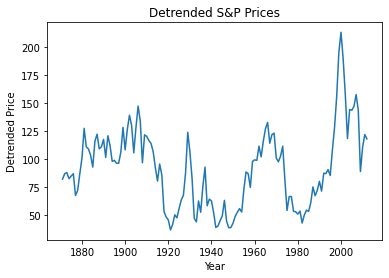

In [87]:
# Plot detrended prices
plt.plot(snp['Year'], snp['detrended_P'])
plt.title("Detrended S&P Prices")
plt.xlabel("Year")
plt.ylabel("Detrended Price")

We also want to compute Dividend growth and detrend it in the same manner.

Text(0.5, 1.0, 'Dividends paid over the years')

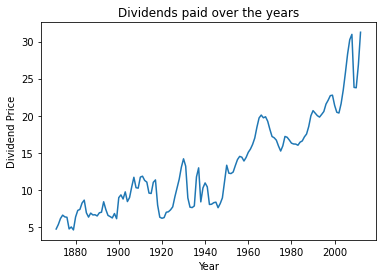

In [88]:
# Plotting dividends
plt.plot(snp['Year'], snp['RealD'])
plt.xlabel("Year")
plt.ylabel("Dividend Price")
plt.title("Dividends paid over the years")

Dividend Growth (g_d): 0.010580466359232155


Text(0.5, 1.0, 'Log Dividend Prices vs. Best Fit')

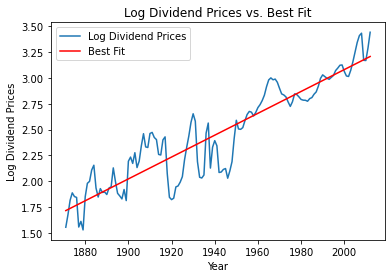

In [90]:

log_d = np.log(snp['RealD']).to_numpy()
# OLS to get gt + log(D_0) = log(D_t)
X = np.vstack([np.ones_like(snp['Year']), snp['Year']]).transpose()
y = log_d
W = np.linalg.inv(X.transpose() @ X) @ (X.transpose() @ y)
g_d = W[1]
print("Dividend Growth (g_d):", W[1])


# best fit line
best_fit_y = W @ X.transpose()

# Plot log prices vs Best fit
plt.plot(snp['Year'], log_d, label = 'Log Dividend Prices')
plt.plot(snp['Year'], best_fit_y, c = 'red', label = 'Best Fit')

plt.xlabel("Year")
plt.ylabel("Log Dividend Prices")
plt.legend()
plt.title("Log Dividend Prices vs. Best Fit")

Text(0.5, 1.0, 'Detrended Dividends')

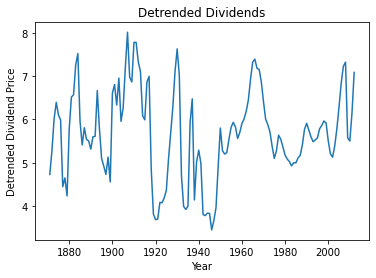

In [93]:
# detrend Dividends
snp['detrended_D'] = snp['RealD']/(1+g_d)**snp.index
# plot detrended
plt.plot(snp['Year'], snp['detrended_D'], label = 'Detrended Dividends')
plt.xlabel("Year")
plt.ylabel("Detrended Dividend Price")
plt.title("Detrended Dividends")